## Решение уравнения переноса 

$$\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = f(t, x)$$

$$c > 0$$

Его частное решение имеет вид:

$$u_0(t, x) = \int\limits^t_0 f(s, x - c(t-s)) ds$$

Действительно:

$\frac{\partial u_0}{\partial t} = f(t,x) - c\int\limits^t_0 f_x(s, x - c(t-s)) ds$

$\frac{\partial u_0}{\partial x} = \int\limits^t_0 f_x(s, x - c(t-s)) ds$

Общее решение:

$$u(t, x) = g(x - ct) + \int\limits^t_0 f(s, x - c(t-s)) ds, \;\; g(q) \in C^1(\mathbb{R})$$

Рассмотрим теперь граничное условие, считая, что $f\Big|_{x<0} = 0$:

$u \Big|_{x=0} = \Psi(t) = g(-ct) + \int\limits^t_0 f(s, c(s-t)) ds = g(-ct)$, т.к. $s < t$

Из начальных условий:

$u \Big|_{t=0} = \varphi(x) = g(x)$

Аналитическое решение заданного уравнения:

$$ \boxed{u = \int\limits^t_0 f(s, x - c(t-s)) ds + \begin{cases} \Psi(t - \frac{x}{c}), x < ct \\ \varphi(x-ct), x \ge ct \end{cases}}$$

Будем решать уравнение в области $\{0 < x < L\} \times \{0 < t < T\}$

$L = 20, \;\; T = 10, \;\; c = 2$

$\Phi(x) = \sin(x/2)$

$\Psi(t) = \sin(t)$

Теперь выберем $f(t, x) = \begin{cases} 1, x \in (\alpha_1,\alpha_2) \\ 0, \text{otherwise} \end{cases}$, где $0 < \alpha_1 < \alpha_2 < L$

$\alpha_1 < x - c(t - s) < \alpha_2 \Rightarrow \frac{\alpha_1 - x + ct}{c} = s_{\text{min}} < s < s_{\text{max}} = \frac{\alpha_2 - x + ct}{c}$

$\int\limits^t_0 f(s, x - c(t-s)) ds = \max\{0, \int\limits^{\min\{t, s_{\text{max}}\}}_{\max\{0, s_{\text{min}}\}} ds \} = \frac{1}{c}\max\{0, \min\{x, \alpha_2\} - \max\{x - ct, \alpha_1\} \}$

Окончательно выберем $\alpha_1 = 5, \;\; \alpha_2 = 10$

Теперь, когда мы значем точное решение уравнения, получим численные решения с помощью разностных схем и оценим их точность.

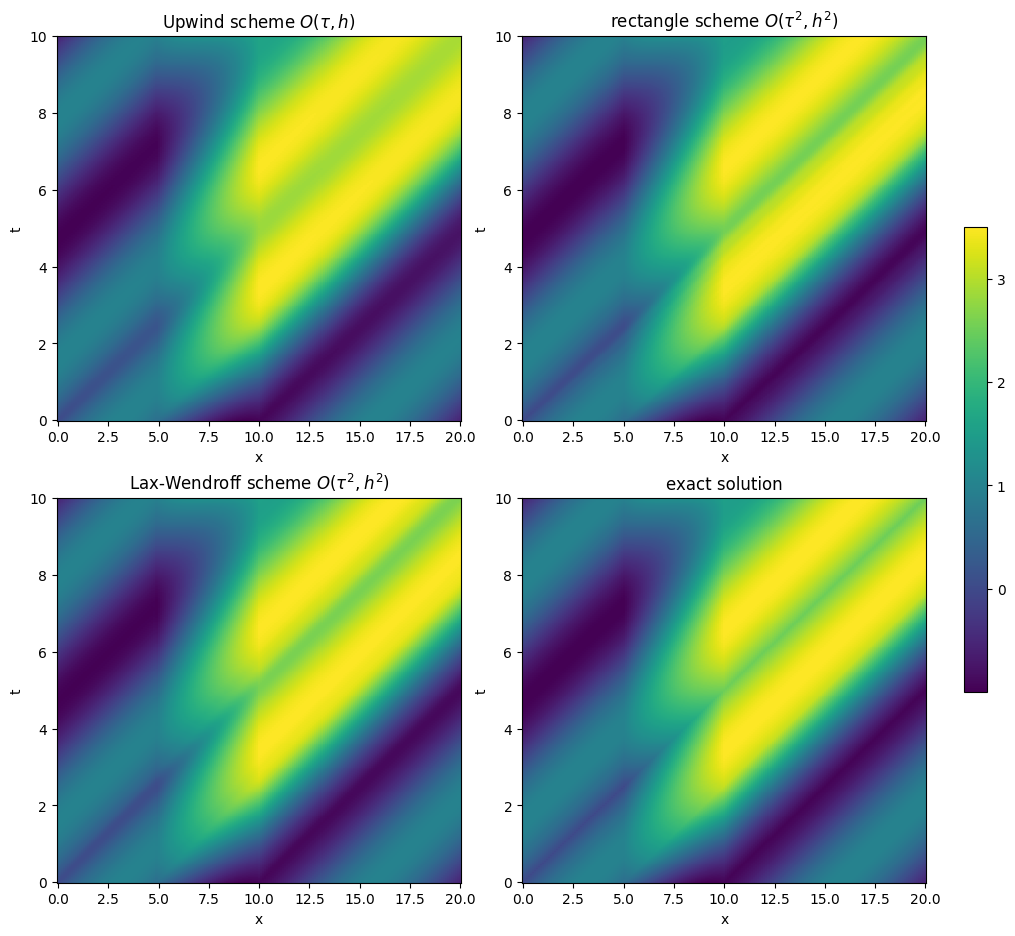

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PDElib import * # CESolver(methods for solving convection equations), Grid
from math import *

c = 2
L = 20
T = 10
grid = Grid(T, 400, L, 200)

def phi(x : float):
    return sin(x / 2)

def psi(t : float):
    return sin(t)

def f(t : float, x : float):
    if (x < 5) or (x > 10):
        return 0
    return 1

def u_exact(t : float, x : float):
    i = max(0, min(x, 10) - max(x - c*t, 5))/c
    if x > c*t:
        return i + phi(x - c*t)
    return i + psi(t - x/c)

def show_results(u_plots: list[tuple[str, list[list[float]]]], grid : Grid):
    tau = grid.T / grid.N
    h = grid.L / grid.M
    x = [h * m for m in range(grid.M + 1)]
    t = [tau * n for n in range(grid.N + 1)]
    fig = plt.figure(figsize=(12, 11))
    gs = gridspec.GridSpec(2, 2, wspace=0.15, hspace=0.2)
    axes = []
    plots = []
    for i in range(4):
        ax = fig.add_subplot(gs[i])
        c = ax.pcolormesh(x, t, u_plots[i][1])
        ax.set_title(u_plots[i][0])
        ax.set_xlabel("x")
        ax.set_ylabel("t")
        axes.append(ax)
        plots.append(c)
    fig.colorbar(plots[0], ax=axes, orientation='vertical', fraction=0.025, pad=0.04)
    plt.show()

h = grid.L / grid.M
tau = grid.T / grid.N
show_results([
    ("Upwind scheme $O(\\tau, h)$", CESolver.solve_by_upwind_scheme(c, grid, phi, psi, f)), 
    ("rectangle scheme $O(\\tau^2, h^2)$", CESolver.solve_by_rectangle_scheme(c, grid, phi, psi, f)),
    ("Lax-Wendroff scheme $O(\\tau^2, h^2)$", CESolver.solve_by_Lax_Wendroff_scheme(c, grid, phi, psi, f)),
    ("exact solution", [[u_exact(n*tau, m*h) for m in range(grid.M + 1)] for n in  range(grid.N + 1)])
    ], grid)

## Оценка погрешности

При оценки погрешности будем удерживать число Куранта $\frac{c\tau}{h} = 0.5 \Rightarrow \tau = \frac{h}{2c}$

Построим графики зависимости ошибки от шага по пространству в двойном логарифмическом масштабе и оценим порядки схем по углам наклона.

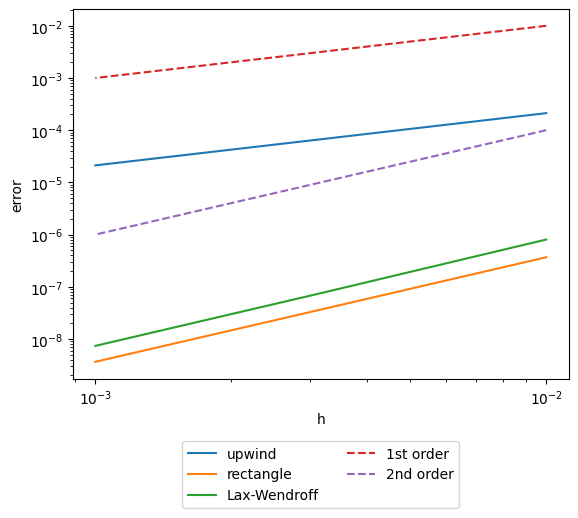

In [ ]:
upwind_errs = []
rect_errs = []
LW_errs = []
hs = []

def get_error(u : list[list[float]], grid : Grid):
    err2 = 0
    h = grid.L / grid.M
    tau = grid.T / grid.N
    for m in range(grid.M + 1):
        err2 += abs(u[grid.N][m] - u_exact(grid.N*tau, m*h))**2
    return sqrt(err2 / grid.M)

for M in [100, 320, 1000]:
    grid = Grid(1, int(2*c*M), 1, M)
    upwind_errs += [get_error(CESolver.solve_by_upwind_scheme(c, grid, phi, psi, f), grid)]
    rect_errs += [get_error(CESolver.solve_by_rectangle_scheme(c, grid, phi, psi, f), grid)]
    LW_errs += [get_error(CESolver.solve_by_Lax_Wendroff_scheme(c, grid, phi, psi, f), grid)]
    hs += [grid.L / grid.M]

plt.plot(hs, upwind_errs, label="upwind")
plt.plot(hs, rect_errs, label="rectangle")
plt.plot(hs, LW_errs, label="Lax-Wendroff")
plt.plot(hs, [x for x in hs], "--", label="1st order")
plt.plot(hs, [x*x for x in hs], "--", label="2nd order")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("h")
plt.ylabel("error")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)